In [3]:
from keras import layers
from keras import models
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
import keras.backend as K
import librosa
import librosa.display
import pylab
import matplotlib.pyplot as plt
from matplotlib import figure
import gc
from keras_preprocessing.image import ImageDataGenerator
import os
import pickle as plk
import pandas as pd
import numpy as np

In [4]:
#check GPU enabled
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
train_dir = 'E:\\CS224S_final_Project\\data\\melspectrograms\\train\\'
dev_dir = 'E:\\CS224S_final_Project\\data\\melspectrograms\\dev\\'

In [25]:
example = np.load("E:\\CS224S_final_Project\\data\\melspectrograms\\train\\303_0.npy", allow_pickle=True)
input_dim = example[0].shape
print("input dim:", input_dim)

train_index_to_file = {}
idx = 0
for file in os.listdir(train_dir):
    train_index_to_file[idx] = file
    idx += 1
    
dev_index_to_file = {}
idx = 0
for file in os.listdir(dev_dir):
    dev_index_to_file[idx] = file
    idx += 1
    
train_idx = np.array(list(train_index_to_file.keys()))
dev_idx = np.array(list(dev_index_to_file.keys()))
print(train_idx.shape, dev_idx.shape)

input dim: (40, 646)
(3037,) (1154,)


In [32]:
class MelSpectDataGen(Sequence):
    """
    Generates a dataset of log melspectrograms
    """
    def __init__(self, idx, mel_path, idx_to_file,
                 to_fit=True, batch_size=8, dim=input_dim,
                 shuffle=True):
        self.idx = idx
        self.mel_path = mel_path
        self.idx_to_file = idx_to_file
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        """
        numbers of batches per epoch
        """
        return int(np.floor(len(self.idx) / self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.idx)
    
    def __getitem__(self, index):
        """
        returns one batch of data
        """
        idx = self.idx[index * self.batch_size : (index + 1) * self.batch_size]
        files = [self.idx_to_file[i] for i in idx]
        x, y = self.get_data_from_files(files)
        
        if self.to_fit:
            return x, y
        else:
            return x
    
    def get_data_from_files(self, files):
        x = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size, 1))
        
        for i, file in enumerate(files):
            path = os.path.join(self.mel_path, file)
            data = np.load(path, allow_pickle=True)
            x[i,] = self.process_x(data[0])
            y[i,] = data[1]
        
        return x, y
    
    def process_x(self, x):
        #new_x = np.zeros((x.shape[0], x.shape[1]))
        #new_x[:x.shape[0],] = x 

        return x # np.expand_dims(new_x, 2) # create channel size 1
        

In [33]:
# create generators
train_gen = MelSpectDataGen(train_idx, train_dir, train_index_to_file)
dev_gen = MelSpectDataGen(dev_idx, dev_dir, dev_index_to_file)

In [40]:
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras import regularizers, optimizers

model = Sequential()
model.add(Conv1D(32, 5, padding='same',
                 input_shape=input_dim))
model.add(Activation('relu'))
model.add(Conv1D(64, 5))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv1D(64, 5, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 5, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Conv1D(128, 3, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 5, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512)) #change from 512
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizers.RMSprop(lr=0.00001, decay=1e-6),loss="binary_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_65 (Conv1D)           (None, 40, 32)            103392    
_________________________________________________________________
activation_65 (Activation)   (None, 40, 32)            0         
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 36, 64)            10304     
_________________________________________________________________
activation_66 (Activation)   (None, 36, 64)            0         
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 18, 64)            0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 18, 64)            0         
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 18, 64)          

In [41]:
#Fitting keras model, no test gen for now
checkpoint_dir = "E:\\CS224S_final_Project"
checkpoint_path = os.path.join(checkpoint_dir, "cnn_1d_max_pool")
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
history = model.fit_generator(generator=train_gen,
                    validation_data=dev_gen,
                    epochs=300,
                    callbacks=[cp_callback])
model.evaluate_generator(generator=dev_gen)

Epoch 1/300
379/379 [==============================] - 5s 12ms/step - loss: 1.1798 - accuracy: 0.6194 - val_loss: 0.6743 - val_accuracy: 0.5981

Epoch 00001: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 2/300
379/379 [==============================] - 4s 11ms/step - loss: 0.6410 - accuracy: 0.6847 - val_loss: 0.6739 - val_accuracy: 0.5981

Epoch 00002: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 3/300
379/379 [==============================] - 4s 11ms/step - loss: 0.6349 - accuracy: 0.6966 - val_loss: 0.6755 - val_accuracy: 0.5981

Epoch 00003: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 4/300
379/379 [==============================] - 4s 11ms/step - loss: 0.6077 - accuracy: 0.7232 - val_loss: 0.6724 - val_accuracy: 0.5981

Epoch 00004: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 5/300
379/379 [==============================] - 4s 11ms/step - loss: 0.6065 - accuracy: 0.7346 - val_loss: 0.6729 - val_accuracy: 0.5990


379/379 [==============================] - 4s 11ms/step - loss: 0.5673 - accuracy: 0.7168 - val_loss: 0.6570 - val_accuracy: 0.5972

Epoch 00039: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 40/300
379/379 [==============================] - 4s 11ms/step - loss: 0.5795 - accuracy: 0.7064 - val_loss: 0.6567 - val_accuracy: 0.5990

Epoch 00040: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 41/300
379/379 [==============================] - 4s 11ms/step - loss: 0.5507 - accuracy: 0.7243 - val_loss: 0.6573 - val_accuracy: 0.5981

Epoch 00041: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 42/300
379/379 [==============================] - 4s 11ms/step - loss: 0.5633 - accuracy: 0.7138 - val_loss: 0.6568 - val_accuracy: 0.5972

Epoch 00042: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 43/300
379/379 [==============================] - 4s 11ms/step - loss: 0.5744 - accuracy: 0.7114 - val_loss: 0.6571 - val_accuracy: 0.5972

Epoch 0

379/379 [==============================] - 4s 11ms/step - loss: 0.4459 - accuracy: 0.7486 - val_loss: 0.6764 - val_accuracy: 0.5026

Epoch 00077: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 78/300
379/379 [==============================] - 4s 11ms/step - loss: 0.4684 - accuracy: 0.7189 - val_loss: 0.6772 - val_accuracy: 0.4922

Epoch 00078: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 79/300
379/379 [==============================] - 4s 11ms/step - loss: 0.4439 - accuracy: 0.7318 - val_loss: 0.6778 - val_accuracy: 0.4939

Epoch 00079: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 80/300
379/379 [==============================] - 4s 11ms/step - loss: 0.4374 - accuracy: 0.7513 - val_loss: 0.6804 - val_accuracy: 0.4809

Epoch 00080: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 81/300
379/379 [==============================] - 4s 11ms/step - loss: 0.4241 - accuracy: 0.7442 - val_loss: 0.6815 - val_accuracy: 0.4835

Epoch 0

379/379 [==============================] - 4s 11ms/step - loss: 0.3327 - accuracy: 0.8556 - val_loss: 0.8507 - val_accuracy: 0.4488

Epoch 00115: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 116/300
379/379 [==============================] - 4s 11ms/step - loss: 0.3029 - accuracy: 0.8647 - val_loss: 0.8595 - val_accuracy: 0.4514

Epoch 00116: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 117/300
379/379 [==============================] - 4s 11ms/step - loss: 0.3026 - accuracy: 0.8635 - val_loss: 0.8643 - val_accuracy: 0.4540

Epoch 00117: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 118/300
379/379 [==============================] - 4s 11ms/step - loss: 0.2929 - accuracy: 0.8586 - val_loss: 0.8820 - val_accuracy: 0.4575

Epoch 00118: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 119/300
379/379 [==============================] - 4s 11ms/step - loss: 0.3001 - accuracy: 0.8621 - val_loss: 0.8764 - val_accuracy: 0.4488

Epo

Epoch 153/300
379/379 [==============================] - 4s 11ms/step - loss: 0.2354 - accuracy: 0.9072 - val_loss: 1.3406 - val_accuracy: 0.4679

Epoch 00153: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 154/300
379/379 [==============================] - 4s 11ms/step - loss: 0.2233 - accuracy: 0.9079 - val_loss: 1.3754 - val_accuracy: 0.4670

Epoch 00154: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 155/300
379/379 [==============================] - 4s 11ms/step - loss: 0.2141 - accuracy: 0.9148 - val_loss: 1.3100 - val_accuracy: 0.4679

Epoch 00155: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 156/300
379/379 [==============================] - 4s 11ms/step - loss: 0.2145 - accuracy: 0.9127 - val_loss: 1.4179 - val_accuracy: 0.4696

Epoch 00156: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 157/300
379/379 [==============================] - 4s 11ms/step - loss: 0.2150 - accuracy: 0.9108 - val_loss: 1.3902 - val_accurac

Epoch 191/300
379/379 [==============================] - 4s 11ms/step - loss: 0.1712 - accuracy: 0.9394 - val_loss: 1.9192 - val_accuracy: 0.4635

Epoch 00191: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 192/300
379/379 [==============================] - 4s 11ms/step - loss: 0.1947 - accuracy: 0.9316 - val_loss: 2.2067 - val_accuracy: 0.4688

Epoch 00192: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 193/300
379/379 [==============================] - 4s 11ms/step - loss: 0.1582 - accuracy: 0.9428 - val_loss: 2.2020 - val_accuracy: 0.4705

Epoch 00193: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 194/300
379/379 [==============================] - 4s 11ms/step - loss: 0.1768 - accuracy: 0.9366 - val_loss: 2.0169 - val_accuracy: 0.4644

Epoch 00194: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 195/300
379/379 [==============================] - 4s 11ms/step - loss: 0.1465 - accuracy: 0.9498 - val_loss: 2.3162 - val_accurac

Epoch 229/300
379/379 [==============================] - 4s 11ms/step - loss: 0.1510 - accuracy: 0.9451 - val_loss: 2.8686 - val_accuracy: 0.4861

Epoch 00229: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 230/300
379/379 [==============================] - 4s 11ms/step - loss: 0.1662 - accuracy: 0.9380 - val_loss: 2.6489 - val_accuracy: 0.4696

Epoch 00230: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 231/300
379/379 [==============================] - 4s 11ms/step - loss: 0.1519 - accuracy: 0.9408 - val_loss: 2.5341 - val_accuracy: 0.4653

Epoch 00231: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 232/300
379/379 [==============================] - 4s 11ms/step - loss: 0.1565 - accuracy: 0.9462 - val_loss: 2.7021 - val_accuracy: 0.4714

Epoch 00232: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 233/300
379/379 [==============================] - 4s 11ms/step - loss: 0.1535 - accuracy: 0.9474 - val_loss: 2.7756 - val_accurac

Epoch 267/300
379/379 [==============================] - 4s 11ms/step - loss: 0.1408 - accuracy: 0.9473 - val_loss: 2.7145 - val_accuracy: 0.4592

Epoch 00267: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 268/300
379/379 [==============================] - 4s 11ms/step - loss: 0.1139 - accuracy: 0.9577 - val_loss: 2.7240 - val_accuracy: 0.4627

Epoch 00268: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 269/300
379/379 [==============================] - 4s 11ms/step - loss: 0.1422 - accuracy: 0.9459 - val_loss: 2.7357 - val_accuracy: 0.4635

Epoch 00269: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 270/300
379/379 [==============================] - 4s 11ms/step - loss: 0.1308 - accuracy: 0.9479 - val_loss: 2.8962 - val_accuracy: 0.4592

Epoch 00270: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 271/300
379/379 [==============================] - 4s 11ms/step - loss: 0.1248 - accuracy: 0.9503 - val_loss: 2.9377 - val_accurac

[3.096173048019409, 0.4652777910232544]

In [ ]:
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_directory(
    directory="test",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode=None,
    target_size=(64,64))
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

In [13]:
history.history

{'loss': [0.5970097184181213,
  0.5864580869674683,
  0.5733625292778015,
  0.5593507289886475,
  0.5499074459075928,
  0.529107928276062,
  0.5039184093475342,
  0.49000266194343567,
  0.4611984193325043,
  0.4361407458782196,
  0.4101009964942932,
  0.3861428201198578,
  0.3670750558376312,
  0.3522728979587555,
  0.3325035870075226,
  0.3121224343776703,
  0.2907268702983856,
  0.2930213212966919,
  0.2721068859100342,
  0.2542506158351898,
  0.2511141002178192,
  0.2314685732126236,
  0.22735288739204407,
  0.22089965641498566,
  0.20902900397777557,
  0.1775413602590561,
  0.18083719909191132,
  0.1746797114610672,
  0.17320701479911804,
  0.15977928042411804],
 'accuracy': [0.7194675803184509,
  0.7171381115913391,
  0.7174708843231201,
  0.720798671245575,
  0.728723406791687,
  0.7400998473167419,
  0.7527454495429993,
  0.7650582194328308,
  0.7763727307319641,
  0.7946755290031433,
  0.8053244352340698,
  0.8282861709594727,
  0.8296173214912415,
  0.841930091381073,
  0.8552

In [14]:
output = model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)

In [21]:
history.history['val_accuracy']

[0.5980902910232544,
 0.5980902910232544,
 0.5972222089767456,
 0.5963541865348816,
 0.5642361044883728,
 0.5078125,
 0.484375,
 0.5295138955116272,
 0.5251736044883728,
 0.4869791567325592,
 0.5130208134651184,
 0.484375,
 0.5199652910232544,
 0.5138888955116272,
 0.4756944477558136,
 0.4600694477558136,
 0.5269097089767456,
 0.4904513955116272,
 0.5182291865348816,
 0.4131944477558136,
 0.5199652910232544,
 0.4756944477558136,
 0.4600694477558136,
 0.4921875,
 0.4505208432674408,
 0.5355902910232544,
 0.5486111044883728,
 0.5234375,
 0.4635416567325592,
 0.4609375]

In [18]:
output

[1.459011435508728, 0.4618055522441864]

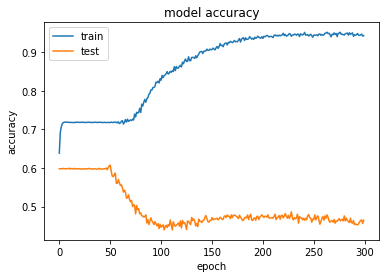

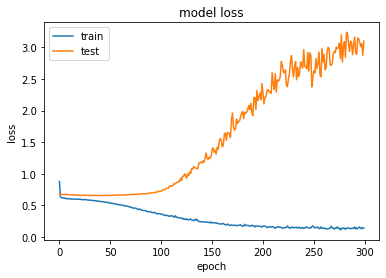

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
history.history

{'loss': [0.5970097184181213,
  0.5864580869674683,
  0.5733625292778015,
  0.5593507289886475,
  0.5499074459075928,
  0.529107928276062,
  0.5039184093475342,
  0.49000266194343567,
  0.4611984193325043,
  0.4361407458782196,
  0.4101009964942932,
  0.3861428201198578,
  0.3670750558376312,
  0.3522728979587555,
  0.3325035870075226,
  0.3121224343776703,
  0.2907268702983856,
  0.2930213212966919,
  0.2721068859100342,
  0.2542506158351898,
  0.2511141002178192,
  0.2314685732126236,
  0.22735288739204407,
  0.22089965641498566,
  0.20902900397777557,
  0.1775413602590561,
  0.18083719909191132,
  0.1746797114610672,
  0.17320701479911804,
  0.15977928042411804],
 'accuracy': [0.7194675803184509,
  0.7171381115913391,
  0.7174708843231201,
  0.720798671245575,
  0.728723406791687,
  0.7400998473167419,
  0.7527454495429993,
  0.7650582194328308,
  0.7763727307319641,
  0.7946755290031433,
  0.8053244352340698,
  0.8282861709594727,
  0.8296173214912415,
  0.841930091381073,
  0.8552